<a href="https://colab.research.google.com/github/jrakhshanda/Text-Mining/blob/main/twitter_sentiment_extaction_analysis_eda_and_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NER for sentiment analysis
[code source](https://www.kaggle.com/nairobii/twitter-sentiment-extaction-analysis-eda-and-model)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Necesseties 

In [7]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
from sklearn import model_selection, metrics
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import nltk
nltk.download('stopwords')

from sklearn import model_selection

import warnings
warnings.filterwarnings("ignore")

import os


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Below is a helper Function which generates random colors which can be used to give different colors to your plots.Feel free to use it**

In [8]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

# Reading the Data

In [97]:
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
train, test = model_selection.train_test_split(df_train,test_size=0.2)

In [98]:
df_train = train.copy()

# EDA

## Generating Meta-Features

**In the previous versions of this notebook,I used Number of words in selected text and main text ,Length of words in text and selected as main meta features,but in the context of this competition where we have to predict selected_text which is a subset of text, more useful features to generate would be** :-
* Difference In Number Of words of Selected_text and Text
* Jaccard Similarity Scores between text and Selected_text

Thus it will not be useful for us to generate features we used before as they are of no importance here

For what who don't know what Jaccard Similarity is : https://www.geeksforgeeks.org/find-the-jaccard-index-and-jaccard-distance-between-the-two-given-sets/

In [99]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [100]:
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = str(row.text)
    sentence2 = str(row.selected_text)

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [101]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')

In [102]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split())) #Number Of words in Selected Text
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train['difference_in_words'] = train['Num_word_text'] - train['Num_words_ST'] #Difference in Number of words text and Selected Text

In [103]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,47baa143d8,back from lunch and I just remembered I have t...,back from lunch and I just remembered I have t...,neutral,1.000000,16,16,0
1,a3603b45fb,its funny you said we`d never make it and look...,funny,positive,0.045455,1,22,21
2,983b7ba96d,"Had fried oreos downtown vegas, went to the pa...",BEST DAY EVERRRR.,positive,0.166667,3,18,15
3,8925d7b678,"Gooooooood morning, campers! And happy Mother...",happy,positive,0.142857,1,7,6
4,4540286356,Gotta work. Lonely weekend ahead.,Lonely weekend ahead.,negative,0.600000,3,5,2


Let's look at the distribution of Meta-Features

In [104]:
hist_data = [train['Num_words_ST'],train['Num_word_text']]

group_labels = ['Selected_Text', 'Text']
plt.rcParams.update({'font.size': 14})
# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
plt.savefig('distribution_of_words.png')
fig.show()

<Figure size 432x288 with 0 Axes>

* The number of words plot is really interesting ,the tweets having number of words greater than 25 are very less and thus the number of words distribution plot is right skewed

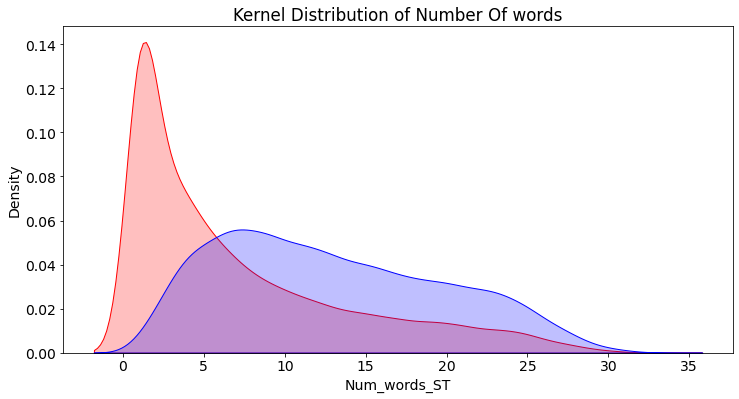

In [105]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="b")

**Now It will be more interesting to see the differnce in number of words and jaccard_scores across different Sentiments**

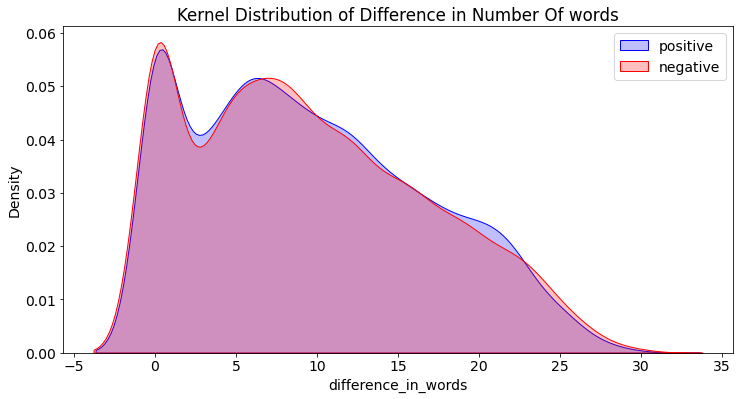

In [108]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in Number Of words')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")
plt.legend(labels=['positive','negative'])

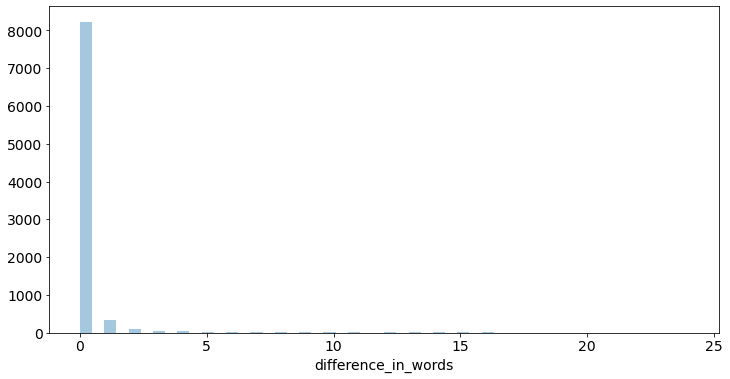

In [107]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['difference_in_words'],kde=False)

I was not able to plot kde plot for neutral tweets because most of the values for difference in number of words were zero. We can see it clearly now ,if we had used the feature in the starting we would have known that text and selected text are mostly the same for neutral tweets,thus its always important to keep the end goal in mind while performing EDA

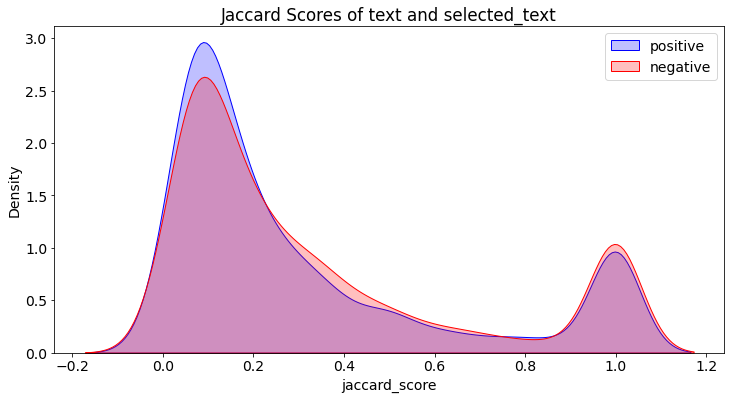

In [117]:
plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 14})
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('Jaccard Scores of text and selected_text')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['positive','negative'])
plt.savefig('jaccs_pos_neg.png')
plt.show()

I was not able to plot kde of jaccard_scores of neutral tweets for the same reason,thus I will plot a distribution plot

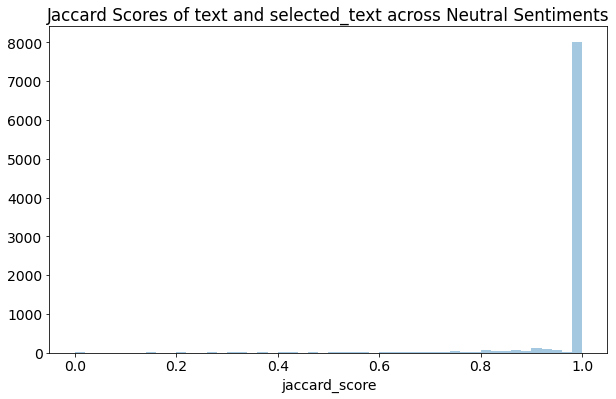

In [120]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 14})
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False).set_title('Jaccard Scores of text and selected_text across Neutral Sentiments')
plt.savefig('jaccs_neutral.png')
plt.show()

We can see some interesting trends here:
* Positive and negative tweets have high kurtosis and thus values are concentrated in two regions narrow and high density 
* Neutral tweets have a low kurtosis value and their is bump in density near values of 1

For those who don't know :
* Kurtosis is the measure of how peaked a distribution is and how much spread it is around that peak
* Skewness measures how much a curve deviates from a normal distribution

## Conclusion Of EDA

* We can see from the jaccard score plot that there is peak for negative and positive plot around score of 1 .That means there is a cluster of tweets where there is a high similarity between text and selected texts ,if we can find those clusters then we can predict text for selected texts for those tweets irrespective of segment

Let's see if we can find those clusters,one interesting idea would be to check tweets which have number of words lesss than 3 in text, because there the text might be completely used as text

In [121]:
k = train[train['Num_word_text']<=2]

In [122]:
k.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.792636
neutral     0.979351
positive    0.754386
Name: jaccard_score, dtype: float64

We can see that there is similarity between text and selected text .Let's have closer look

In [27]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
505,5047df4e16,thanks,thanks,positive,1.0,1,1,0
807,61d5b309ae,thanks!,thanks,positive,0.0,1,1,0
870,b4774eef40,Thanks amigo!,Thanks amigo!,positive,1.0,2,2,0
1011,2c79d99abc,that`s precious,precious,positive,0.5,1,2,1
1624,9752aa6ef0,Goodnight lolsz,Goodnight,positive,0.5,1,2,1
...,...,...,...,...,...,...,...,...
16645,ea816f7a95,Thanks Synn!,Thanks,positive,0.5,1,2,1
16733,8c932ad57c,really? Awesome!,Awesome!,positive,0.5,1,2,1
16792,03f5d78195,Goodmorning world!,Goodmorning,positive,0.5,1,2,1
16976,a3710e95cc,Haha thanks.,thanks.,positive,0.5,1,2,1


Thus its clear that most of the times , text is used as selected text.We can improve this by preprocessing the text which have word length less than 3.We will remember this information and use it in model building

### Cleaning the Corpus
Now Before We Dive into extracting information out of words in text and selected text,let's first clean the data

In [28]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [29]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [30]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_word_text,difference_in_words
0,f17bce53be,going to bed today was another good if unevent...,good,positive,0.100000,1,10,9
1,93d42cc242,watching loudquietloud documentary about the e...,fantastic,positive,0.058824,1,17,16
2,6fc00bea3d,why would you want a clone unboxed a new ima...,its beautiful too bad its not mine,neutral,0.315789,7,21,14
3,5178ae8052,just watched devil wears prada and i want to l...,poor,negative,0.045455,1,23,22
4,f23e32b777,back from comedy night great fun its only midn...,back from comedy night great fun its only midn...,neutral,1.000000,14,14,0


## Most Common words in our Target-Selected Text

In [31]:
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())

def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

In [32]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,im,1110
1,good,792
2,day,669
3,love,592
4,happy,535
5,like,509
6,dont,507
7,get,502
8,go,445
9,cant,414


In [33]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,792
2,day,669
3,love,592
4,happy,535
5,like,509
6,dont,507
7,get,502
8,go,445
9,cant,414
10,going,404


# Most Common words in Text

Let's also look at the most common words in Text

In [37]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [39]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,1317
2,good,968
3,get,947
4,like,890
5,go,789
6,dont,784
7,love,724
8,work,713
9,going,709
10,got,673


So the first two common word was I'm so I removed it and took data from second row

In [40]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

SO we can see the Most common words in Selected text and Text are almost the same,which was obvious

# Most common words Sentiments Wise

Let's look at the most common words in different sentiments

In [41]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [42]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,545
1,love,459
2,happy,445
3,day,288
4,thanks,275
5,great,230
6,fun,185
7,nice,160
8,mothers,158
9,awesome,157


In [43]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [44]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,miss,226
2,sad,211
3,sorry,184
4,bad,161
5,dont,140
6,hate,137
7,cant,135
8,feel,115
9,sucks,106
10,sick,99


In [47]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,get,392
2,go,360
3,dont,330
4,going,315
5,day,312
6,work,300
7,like,299
8,lol,295
9,got,275
10,back,264


In [48]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

* We can see words like get,go,dont,got,u,cant,lol,like are common in all three segments . That's interesting because words like dont and cant are more of negative nature and words like lol are more of positive nature.Does this mean our data is incorrectly labelled , we will have more insights on this after N-gram analysis
* It will be interesting to see the word unique to different sentiments

## Let's Look at Unique Words in each Segment

We will look at unique words in each segment in the Following Order:
* Positive
* Negative
* Neutral

In [50]:
raw_text = [word for word_list in train['temp_list1'] for word in word_list]

In [51]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

### Positive Tweets

In [52]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,18
1,sandwich,6
2,valley,6
3,greetings,6
4,appreciated,6
5,journey,5
6,presents,5
7,mcr,5
8,honored,5
9,brilliant,5


Text(0.5, 1.0, 'Unique Positive Words')

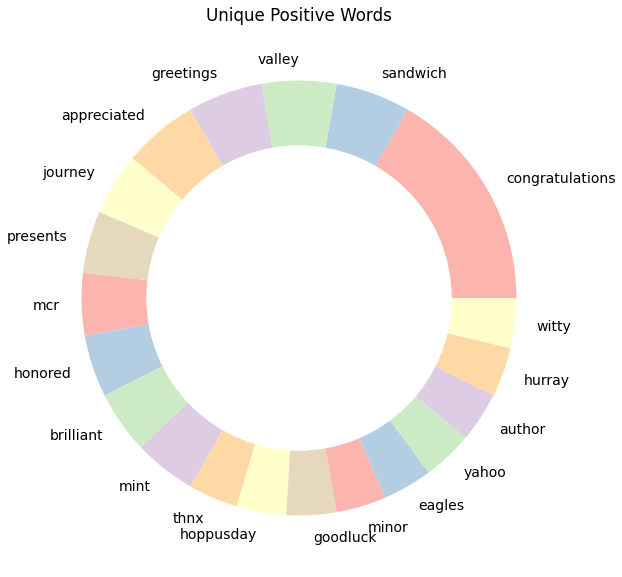

In [70]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 14})
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Positive['count'], labels=Unique_Positive.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Unique Positive Words')
#plt.savefig('unique_pos.png')

In [62]:
Unique_Negative= words_unique('negative', 20, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,ache,10
1,depressed,10
2,suffering,8
3,sadness,6
4,pissing,6
5,frustrated,6
6,sob,5
7,asthma,5
8,frustrating,5
9,allergic,5


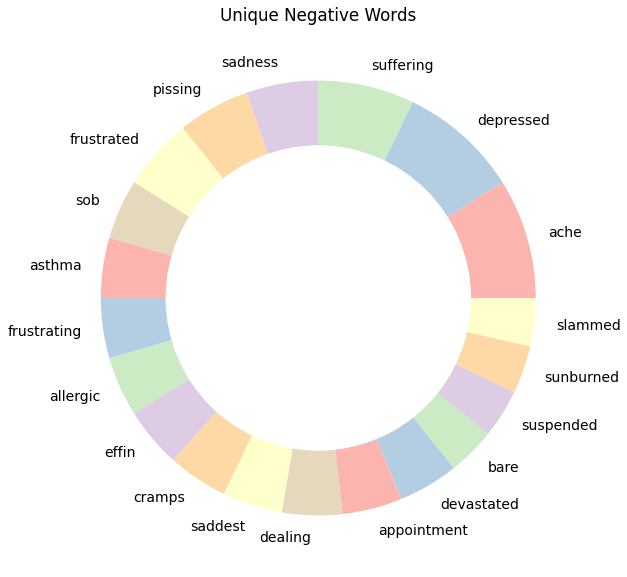

In [71]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 14})
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Unique Negative Words')
plt.savefig('unique_neg.png')
plt.show()

In [72]:
Unique_Neutral= words_unique('neutral', 15, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,explain,7
1,wassup,6
2,settings,6
3,borrow,6
4,greys,5
5,gon,5
6,resist,5
7,sorta,5
8,pens,5
9,bucks,5


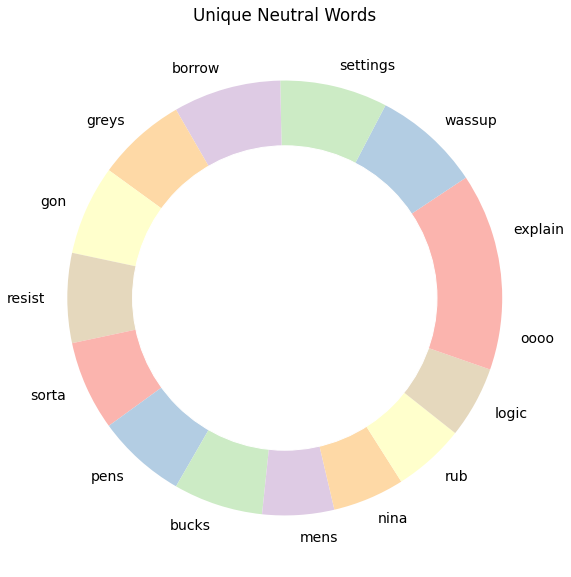

In [75]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 14})
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Neutral['count'], labels=Unique_Neutral.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Unique Neutral Words')
plt.savefig('unique_neutral.png')
plt.show()

**By Looking at the Unique Words of each sentiment,we now have much more clarity about the data,these unique words are very strong determiners of Sentiment of tweets**

# Modelling

This is the first kaggle competition , I am participating in and this might be the case with lot of us.Due to the unique structure of the problem statement, it is hard for any first timer or a competitions noob to answer the question"Which Model to Use"?.My initial thoughts was this competition is not for me and I am done here,but then I remembered something, I was at the KaggleDays Meetup Delhi this year and I had this wonderful oppurtunity to meet Grandmaster Abhishek Thakur and during the Q&A session I asked him that kaggle competitions are so diverse ,unique ,require a lot of background knowledge and thus is scary to participate, to which he replied and I quote "Scary Yes!But so is walking into a dark room,you will never learn if you won't participate".

So here I am fighting my way through this competition and trying to learn different things and I urge everyone to do the same , I might not be so well established to give advices but I really wanted to share that story to motivate people.

After going through the discussion forums,taking advices from experts and watching Abhishek Sir's tutorial last night ,this problem can be modelled as following:-
* Named Entity Recognition
* Q&A Problem
* I also found a simple approach shared by Nick in his beautiful kernel where he has the concept of Gini Impurity to give weights to words present in tweets and then predicting using the weight of those words : https://www.kaggle.com/nkoprowicz/a-simple-solution-using-only-word-counts/notebook .Do check it out.
* Other Modelling Ideas :- https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/139803 --> Here is a very Nice Idea
* Another useful Idea :- https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/139335

Resources :
* For Modelling Problem as NER : https://www.kaggle.com/rohitsingh9990/ner-training-using-spacy-0-628-lb
* For Modelling Problem AS Q&A : https://www.kaggle.com/jonathanbesomi/question-answering-starter-pack ---> This is a complete Guide and From scratch

## 1)Modelling the Problem as NER

Named Entity Recognition (NER) is a standard NLP problem which involves spotting named entities (people, places, organizations etc.) from a chunk of text, and classifying them into a predefined set of categories.
For understanding NER here is very good article : https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da

We will be using spacy for creating our own customised NER model or models (seperate for each Sentiment).The motivation for this approach is off course the kernel shared by Rohit Singh,so if you find his kernel useful please upvote it.

What will be different with my solution:
* I will use text as selected_text for all neutral tweets due to their high jaccard similarity
* Also I will use text as selected_text for all tweets having number of words less than 3 in text as explained before
* I will train two different models for Positive and Negtive tweets
* I will not preprocess the data because the selected text contains raw text

In [123]:
df_train['Num_words_text'] = df_train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main Text in train set

In [124]:
df_train = df_train[df_train['Num_words_text']>=3]

**For Full Understanding of the how to train spacy NER with custom inputs, please read the spacy documentation along with the code presentation in this notebook : https://spacy.io/usage/training#ner Follow along from Updating Spacy NER**

In [134]:
def save_model(output_dir, nlp, new_model_name):
    ''' This Function Saves model to 
    given output directory'''
    
    output_dir = '/content/drive/MyDrive/ner'
    # if output_dir is not None:        
    #     if not os.path.exists(output_dir):
    #         os.makedirs(output_dir)
    #     nlp.meta["name"] = new_model_name
    #     nlp.to_disk(output_dir)
    print("Saved model to", output_dir)

In [135]:
# pass model = nlp if you want to train on top of existing model 

def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts,  # batch of texts
                            annotations,  # batch of annotations
                            drop=0.5,   # dropout - make it harder to memorise data
                            losses=losses, 
                            )
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [136]:
def get_model_out_path(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'model_pos'
    elif sentiment == 'negative':
        model_out_path = 'model_neg'
    return model_out_path

In [137]:
def get_training_data(sentiment):
    '''
    Returns Trainong data in the format needed to train spacy NER
    '''
    train_data = []
    for index, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

#### Training models for Positive and Negative tweets

In [ ]:
sentiment = 'positive'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)
# For demo Purposes I have taken 3 iterations you can train the model as you want
train(train_data, model_path, n_iter=5, model=None)


  0%|          | 0/5 [00:00<?, ?it/s]

Created blank 'en' model


In [130]:
sentiment = 'negative'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=5, model=None)


  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model



 33%|███▎      | 1/3 [00:33<01:06, 33.27s/it]

Losses {'ner': 26010.315026713186}



 67%|██████▋   | 2/3 [01:05<00:33, 33.02s/it]

Losses {'ner': 23461.38887500479}



100%|██████████| 3/3 [01:38<00:00, 32.80s/it]

Losses {'ner': 21630.877963523795}
Saved model to ../working/models/model_neg


### Predicting with the trained Model

In [132]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [133]:
selected_texts = []
MODELS_BASE_PATH = '/content/drive/MyDrive/ner/models/'

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
        
    for index, row in df_test.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))
        
df_test['selected_text'] = selected_texts

Loading Models  from  ../input/tse-spacy-model/models/


OSError: ignored

In [ ]:
df_submission['selected_text'] = df_test['selected_text']
df_submission.to_csv("submission.csv", index=False)
display(df_submission.head(10))

# End Notes
Kaggle always provide a lot of days for a competition which one can utilize to learn and grow.As Promised I have presented my first model,along with explanation,you can read spacy's documentation and Rohit singh's kernel as all the code comes from their.If you understand any part of code feel free to comment and ask,I will try to resolve it.
As This is my first competition I am also learning along the way ,I will be back with more original ideas and some great more models as I learn more and more about question/answering , different other texhniques , various forms of BERT and Data itself

** Thanks for the enormous love and appreciation , I'm Sorry that I have not updated the kernel with Q and A approach,I'm Still learning all the techniques required , will update soon!**
<br><br>STAY TUNED!

<span style="color:Red"> I hope you Liked my kernel. An upvote is a gesture of appreciation and encouragement that fills me with energy to keep improving my efforts ,be kind to show one ;-)